## Continuous Data

### Con_1_coef

C:\Users\11932\AppData\Local\Temp\ipykernel_30324\1346159757.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
C:\Users\11932\AppData\Local\Temp\ipykernel_30324\1346159757.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),


IndexError: index 2 is out of bounds for axis 0 with size 2

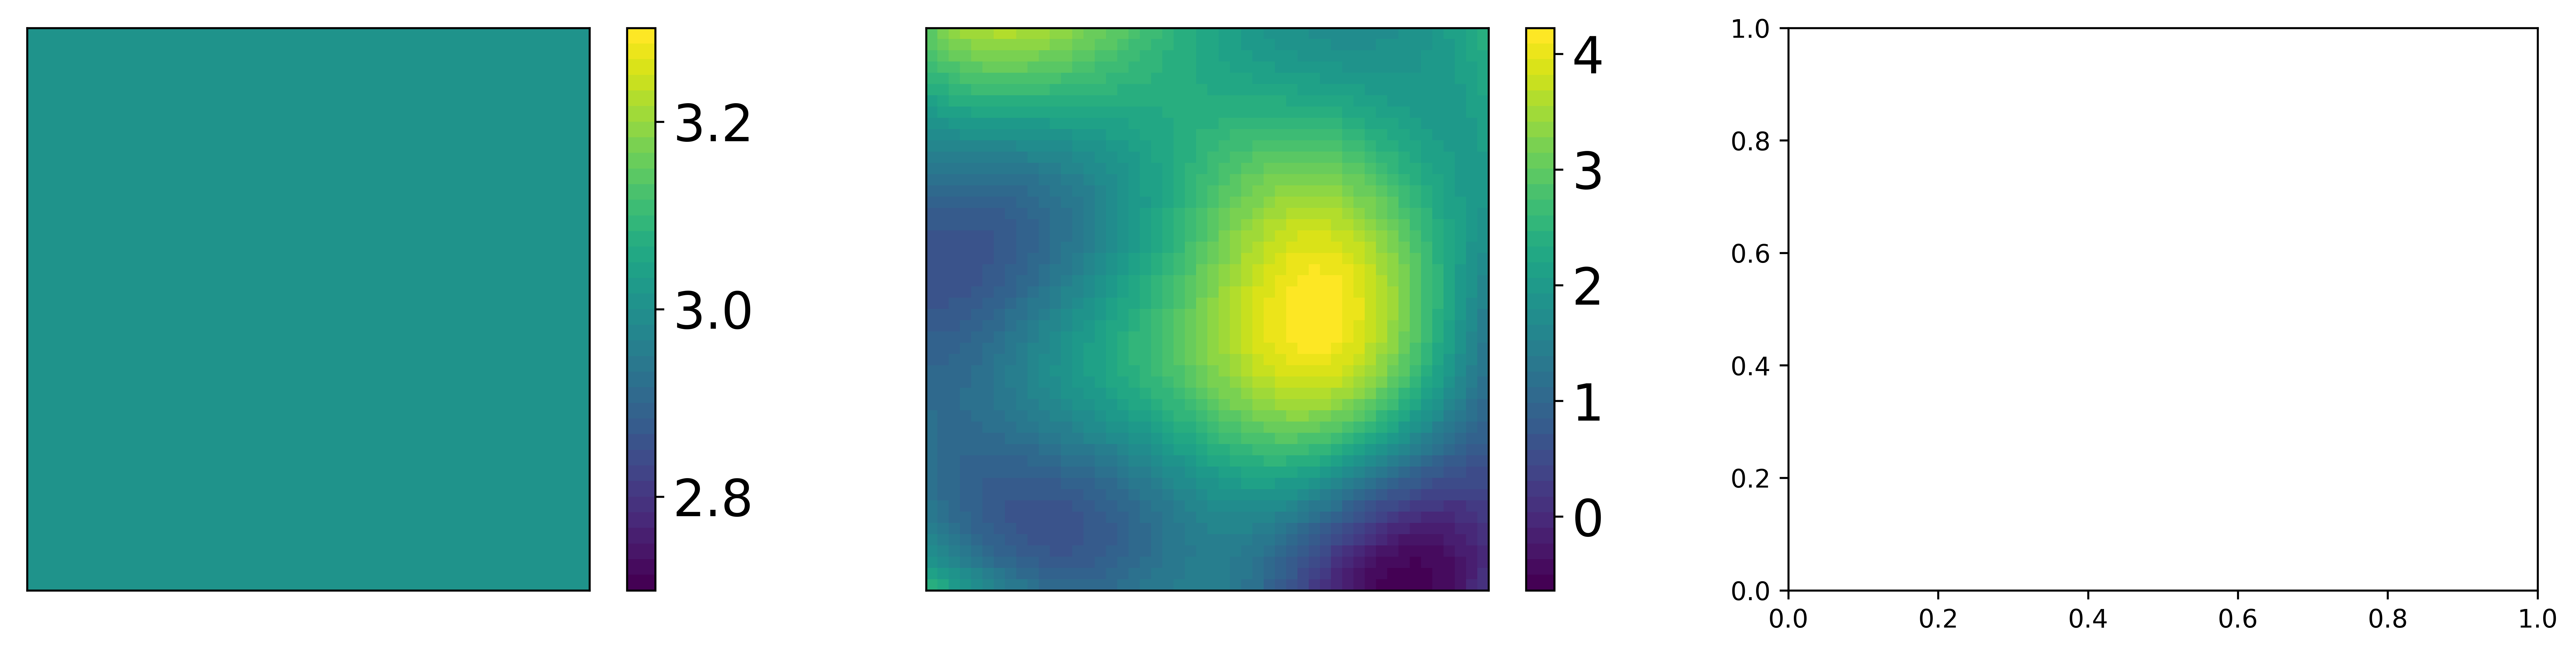

In [155]:
import pylab as plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian,CovModel
class GWR_gau(CovModel):
    def correlation(self,r):
        return np.exp(-0.5*(r/self.len_scale)**2)

params = {'legend.fontsize': 16}
plot.rcParams.update(params)

def plot_s(b,sub_title=['','','','',''],title="",non_spatial=[],vmin=None,vmax=None,interpolation=None):
    k = 3
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=600)
    for i in range(k):
        for m in non_spatial:
            if i == m[0]: 
                ax = axs[i].scatter(m[1],m[2],s=5,color="black")
                axs[i].set_ylim([m[3],m[4]])
                axs[i].set_xlim([-2.5,2.5])
                #axs[i].set_ylabel(r'$\phi_{}$'.format(i),fontsize=16)
                axs[i].set_xlabel(r'$X_{}$'.format(i),fontsize=20)
                
                axs[i].xaxis.set_tick_params(labelsize=20)
                axs[i].yaxis.set_tick_params(labelsize=20)
                
                
                break
                
        else:
            ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax,interpolation=interpolation)
        
            cb = fig.colorbar(ax, ax=axs[i])
            cb.ax.tick_params(labelsize=20)

            axs[i].set_xticks(np.arange(-0.5, size, 5))
            axs[i].set_yticks(np.arange(-0.5, size, 5))
            axs[i].set_xticklabels([])
            axs[i].set_yticklabels([])
        
            axs[i].tick_params(axis='x', colors=(0,0,0,0))
            axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
        axs[i].set_title(sub_title[i],fontsize=25,y=1.05)
    
    #fig.suptitle(title, fontsize=25,y=1.1)
    
    #plt.tight_layout()
        
    
    #plt.savefig(title + ".png",bbox_inches='tight')

size=50
np.random.seed(222)


X1 = np.random.uniform(-2,2,size*size)
#X2 = np.random.uniform(-2,2,size*size)

err = np.random.randn(size*size)

X = np.vstack([X1]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1];n = X.shape[0]
names=['X1','x_coord','y_coord']

X_coords = pd.DataFrame(np.concatenate([X,coords,],axis=1),columns=names)

X_coords = (X_coords - X_coords.mean(axis=0))/X_coords.std(axis=0)

b0 = np.ones((size*size,)) * 3
model = GWR_gau(dim=2, var=1,len_scale=12)
srf = SRF(model,mean=0,seed=2)

b1 = srf.structured([range(size),range(size)]).reshape(-1)
b1 = ((b1 - b1.mean())/b1.std() + 2)

f0 = b0

f1 = b1*X_coords.values[:,0]

err = np.random.randn(n)

y = pd.DataFrame(f0 + f1 +err ,columns=['y'])
plot_s(np.vstack([b0,b1]),title="Data Generating Processes")

In [2]:
#   u = np.array([np.linspace(0,size-1,size)]*size).reshape(-1)
#   v = np.array([np.linspace(0,size-1,size)]*size).T.reshape(-1)

df_con1 = pd.DataFrame({
    'u':     u.astype(int),      
    'v':     v.astype(int),
    'x_coord': X_coords['x_coord'],
    'y_coord': X_coords['y_coord'],
    'coef0': b0,
    'coef1': b1,
    'feat1': X_coords['X1'],
    'y': y.values.flatten()  # 如果 y 是 DataFrame
})

df_con1.to_csv('Continuous_data_1_coef.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_con1.shape)

generate data shape = (2500, 8)


### Dis_Con_data

In [172]:
n = size * size

# feat2
X2 = np.random.uniform(-2, 2, n)
X2 = (X2 - X2.mean()) / X2.std()
df_con1['feat2'] = X2

#离散化连续 coef1
disc = np.where(
    df_con1['coef1'] < 0,
    np.floor(df_con1['coef1']),
    np.ceil(df_con1['coef1'])
).astype(int)
disc = np.minimum(disc, 4)  # 上限截断 4

# coef1 = -coef2
df_con1['coef1'] = disc
df_con1['coef2'] = -disc

# y
err = np.random.randn(n)
df_con1['y'] = (
    + df_con1['coef1'] * df_con1['feat1']
    + df_con1['coef2'] * df_con1['feat2']
    + df_con1['coef0']
    + err
)


df_out = df_con1[['u','v','x_coord','y_coord','coef0','coef1','coef2','feat1','feat2','y']]
df_out.to_csv(
    'dis_con_2_coef.txt',
    sep='\t',
    index=False,
    float_format='%.6f'
)

print("discrete dataset shape:", df_out.shape)

discrete dataset shape: (2500, 10)


   u  v   x_coord  y_coord  coef0  coef1  coef2     feat1     feat2          y
0  0  0 -1.697410 -1.69741    3.0      4     -4  0.127465  1.416545   0.140526
1  1  0 -1.628128 -1.69741    3.0      4     -4  0.681746  0.670956   6.342690
2  2  0 -1.558846 -1.69741    3.0      4     -4  1.204947 -1.087615  14.136194
3  3  0 -1.489564 -1.69741    3.0      4     -4  0.571954 -1.119027  11.987693
4  4  0 -1.420282 -1.69741    3.0      4     -4 -1.574142 -0.928726   4.756149


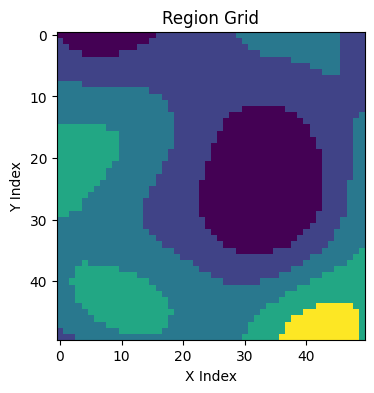

In [208]:
df_test = pd.read_csv("dis_con_2_coef.txt", sep="\t", header=0)

print(df_test.head())

size_x = len(np.unique(df_test['v']))
size_y = len(np.unique(df_test['u']))

region_array = df_test.sort_values(['v','u'])['coef2'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='viridis')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

C:\Users\11932\AppData\Local\Temp\ipykernel_30324\1346159757.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
C:\Users\11932\AppData\Local\Temp\ipykernel_30324\1346159757.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
C:\Users\11932\AppData\Local\Temp\ipykernel_30324\1346159757.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or

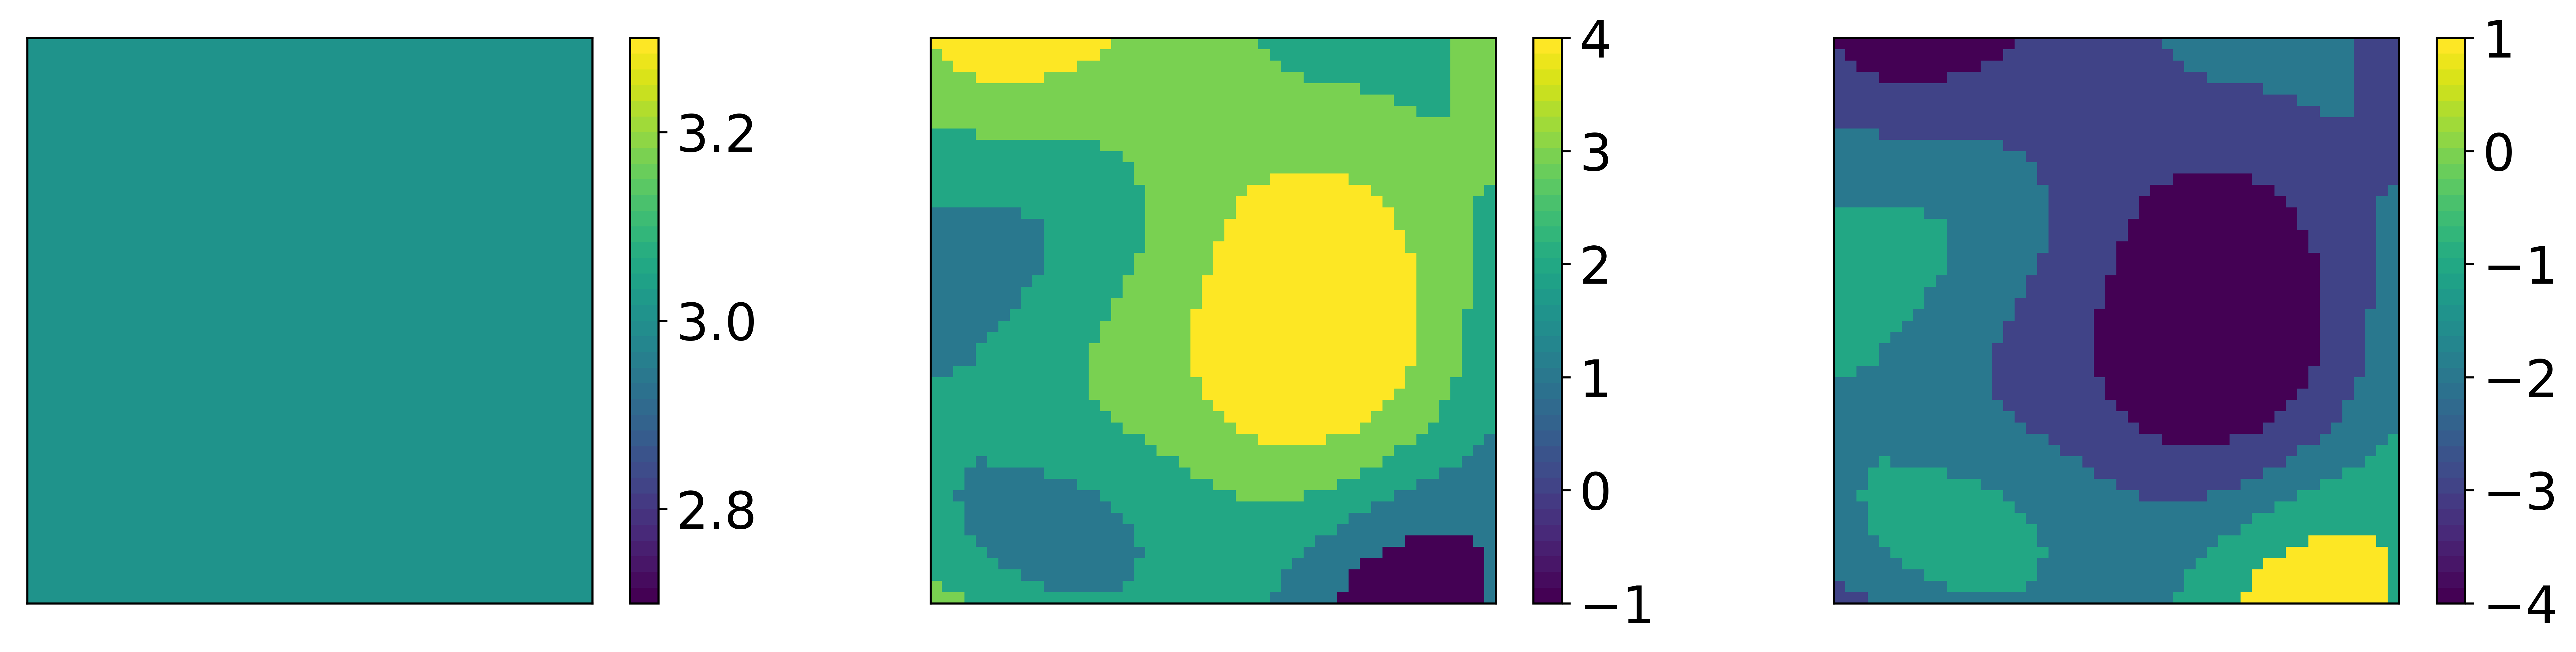

In [157]:
plot_s(np.vstack([b0,disc,disc_2]))

In [ ]:
df_con1 = pd.DataFrame({
    'u':     u.astype(int),
    'v':     v.astype(int),
    'x_coord': X_coords['x_coord'],
    'y_coord': X_coords['y_coord'],
    'coef0': b0,
    'coef1': b1,
    'feat1': X_coords['X1'],
    'y': y.values.flatten()   # 如果 y 是 DataFrame
})

df_con1.to_csv('Continuous_data_1_coef.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_con1.shape)

### Discretely Clustered

### Striped

   spatial_x  spatial_y  a1_list  a2_list  b_list     feat1     feat2  \
0   0.000000        0.0      4.0     -2.0     0.0  0.496714  0.570613   
1   0.204082        0.0      4.0     -2.0     0.0 -0.138264  0.968185   
2   0.408163        0.0      4.0     -2.0     0.0  0.647689 -0.331308   
3   0.612245        0.0      4.0     -2.0     0.0  1.523030 -0.612237   
4   0.816327        0.0      4.0     -2.0     0.0 -0.234153 -1.085151   
5   1.020408        0.0      4.0     -2.0     0.0 -0.234137 -0.825411   
6   1.224490        0.0      4.0     -2.0     0.0  1.579213  2.949094   
7   1.428571        0.0      4.0     -2.0     0.0  0.767435  1.244680   
8   1.632653        0.0      4.0     -2.0     0.0 -0.469474 -1.351074   
9   1.836735        0.0      4.0     -2.0     0.0  0.542560 -1.322458   

          y  region           geometry  
0  0.633751       1        POINT (0 0)  
1 -2.716134       1  POINT (0.20408 0)  
2  2.355549       1  POINT (0.40816 0)  
3  7.151548       1  POINT (0.61

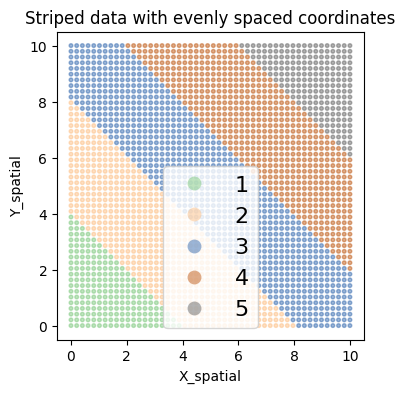

In [145]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def generate_striped_data(n_points=500, 
                          x_min=0, x_max=10,
                          y_min=0, y_max=10,
                          random_seed=42):
    """
    生成一个矩形 [x_min, x_max] x [y_min, y_max] 范围内的均匀点数据，
    用 4 条线 x+y = {2,4,6,8} 把平面分成 5 条倾斜带，每个带用不同的线性模型来生成 y 值。
    返回一个带有 (spatial_x, spatial_y, feat1, feat2, y, region) 列的 GeoDataFrame。
    """
    np.random.seed(random_seed)

    #生成空间坐标点
    #n_x = 50
    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))

    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)

    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    #生成特征
    feat1 = np.random.normal(loc=0.0, scale=1.0, size=n_points)
    feat2 = np.random.normal(loc=0.0, scale=1.0, size=n_points)

    #分区
    xy_sum = x_spatial + y_spatial
    #region = np.full(n_points, 5)
    #region[xy_sum < 3] = 1
    #region[(xy_sum >= 3) & (xy_sum < 6)] = 2.5
    #region[(xy_sum >= 6) & (xy_sum < 9)] = 3
    #region[(xy_sum >= 9) & (xy_sum < 13)] = 4
    min_sum, max_sum = xy_sum.min(), xy_sum.max()
    thresholds = np.linspace(min_sum, max_sum, num=6)[1:-1]
    region = np.digitize(xy_sum, bins=thresholds) + 1


    a1_list = [4.0, 2.0, 0.5,  -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3, -0.5,  3.0]
    b_list  = [0.0, 1.0, 5.0,  0.0,   10.0]

    y = np.zeros(n_points)
    a1_array = np.zeros(n_points)
    a2_array = np.zeros(n_points)
    b_array = np.zeros(n_points)
    for i in range(n_points):
        r = region[i] - 1
        noise = np.random.normal(loc=0.0, scale=0.5)
        y[i] = a1_list[r] * feat1[i] + a2_list[r] * feat2[i] + b_list[r] + noise
        a1_array[i] = a1_list[r]
        a2_array[i] = a2_list[r]
        b_array[i] = b_list[r]

    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
        'region': region
    })

    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return df, gdf


df_striped, gdf_data = generate_striped_data(n_points=2500)
print(gdf_data.head(10))
print(df_striped.head(10))

ax = gdf_data.plot(column='region', categorical=True, legend=True, cmap='Accent',
                   alpha=0.5, figsize=(6,4), s = 7)
ax.set_title("Striped data with evenly spaced coordinates")
ax.set_xlabel("X_spatial")
ax.set_ylabel("Y_spatial")
plt.show()

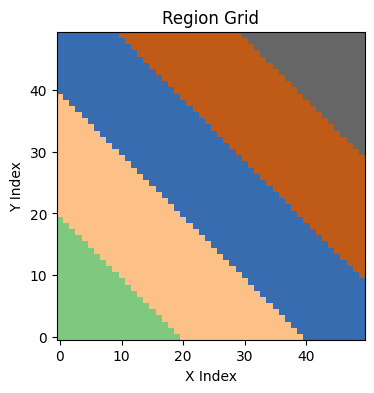

In [146]:
size_x = len(np.unique(df_striped['spatial_x']))
size_y = len(np.unique(df_striped['spatial_y']))

region_array = df_striped.sort_values(['spatial_y','spatial_x'])['region'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='Accent', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

In [21]:
df_striped_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_striped['spatial_x'],
    'y_coord': df_striped['spatial_y'],
    'coef0': df_striped['b_list'],
    'coef1': df_striped['a1_list'],
    'coef2': df_striped['a2_list'],
    'feat1':df_striped['feat1'],
    'feat2': df_striped['feat2'],
    'y': df_striped['y'],
    'region': df_striped['region']
})

df_striped_data.to_csv('striped_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_striped_data.shape)

generate data shape = (2500, 11)


### Voronoi

In [102]:
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd

def generate_voronoi_data(n_points=500, 
                                  x_min=0, x_max=10,
                                  y_min=0, y_max=10,
                                  random_seed=42):
    np.random.seed(random_seed)

    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    feat1 = np.random.normal(0, 1, n_points)
    feat2 = np.random.normal(0, 1, n_points)

    # Voronoi 分区, 随机 5 个 seed
    seed_idx = np.random.choice(n_points, size=5, replace=False)
    seed_x = x_spatial[seed_idx]
    seed_y = y_spatial[seed_idx]

    region = np.empty(n_points, dtype=int)
    # 对每个点，找最近的 seed 赋 region
    for i in range(n_points):
        d2 = (x_spatial[i] - seed_x)**2 + (y_spatial[i] - seed_y)**2
        region[i] = np.argmin(d2) + 1   # +1 让 region 从 1 到 5

    # y, a1, a2
    a1_list = [4.0, 2.0, 0.5, -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3.0, -0.5, 3.0]
    b_list  = [0.0, 1.0, 5.0, 0.0, 10.0]

    y = np.zeros(n_points)
    a1_array = np.zeros(n_points)
    a2_array = np.zeros(n_points)
    b_array = np.zeros(n_points)
    for i in range(n_points):
        r = region[i] - 1
        noise = np.random.normal(loc=0.0, scale=0.5)
        y[i] = a1_list[r] * feat1[i] + a2_list[r] * feat2[i] + b_list[r] + noise
        a1_array[i] = a1_list[r]
        a2_array[i] = a2_list[r]
        b_array[i] = b_list[r]


    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
        'region': region
    })

    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return df, gdf


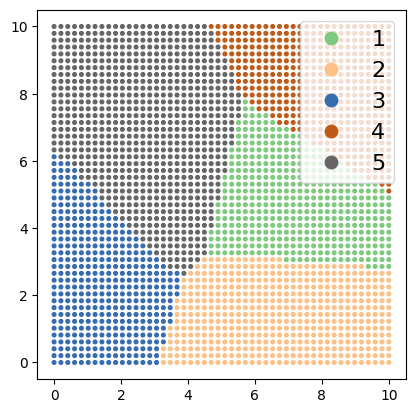

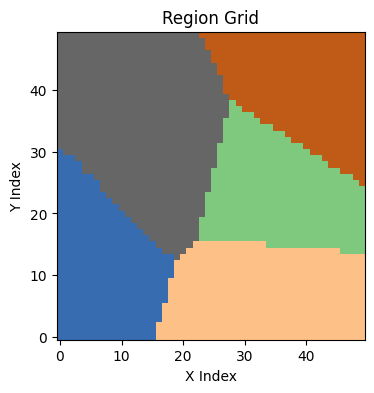

In [103]:
df_voronoi,gdf_voronoi = generate_voronoi_data(2500)
gdf_voronoi.plot(column='region', categorical=True, cmap='Accent', legend=True, s=7)

size_x = len(np.unique(df_voronoi['spatial_x']))
size_y = len(np.unique(df_voronoi['spatial_y']))

region_array = df_voronoi.sort_values(['spatial_y','spatial_x'])['region'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='Accent', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

In [20]:
df_voronoi_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_voronoi['spatial_x'],
    'y_coord': df_voronoi['spatial_y'],
    'coef0': df_voronoi['b_list'],
    'coef1': df_voronoi['a1_list'],
    'coef2': df_voronoi['a2_list'],
    'feat1':df_voronoi['feat1'],
    'feat2': df_voronoi['feat2'],
    'y': df_voronoi['y'],
    'region': df_voronoi['region']
})

df_voronoi_data.to_csv('voronoi_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_voronoi_data.shape)

generate data shape = (2500, 11)


   u  v   x_coord  y_coord  coef0  coef1  coef2     feat1     feat2         y  \
0  0  0  0.000000      0.0    5.0    0.5   -3.0  0.496714  0.570613  4.436558   
1  1  0  0.204082      0.0    5.0    0.5   -3.0 -0.138264  0.968185  1.991473   
2  2  0  0.408163      0.0    5.0    0.5   -3.0  0.647689 -0.331308  7.084271   
3  3  0  0.612245      0.0    5.0    0.5   -3.0  1.523030 -0.612237  8.204594   
4  4  0  0.816327      0.0    5.0    0.5   -3.0 -0.234153 -1.085151  7.825769   

   region  
0       3  
1       3  
2       3  
3       3  
4       3  


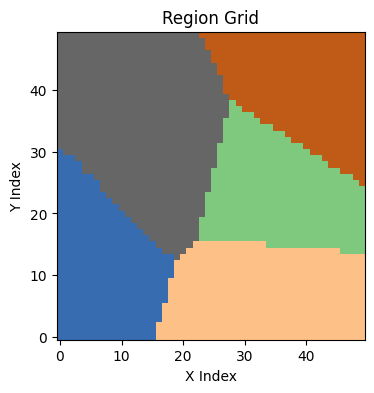

In [30]:
df_test = pd.read_csv("voronoi_data.txt", sep="\t", header=0)

print(df_test.head())

size_x = len(np.unique(df_test['v']))
size_y = len(np.unique(df_test['u']))

region_array = df_test.sort_values(['v','u'])['region'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='Accent', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

### Circle

In [52]:
def generate_circle_data(n_points=500, 
                                  x_min=0, x_max=10,
                                  y_min=0, y_max=10,
                                  random_seed=42):
    np.random.seed(random_seed)

    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    feat1 = np.random.normal(0, 1, n_points)
    feat2 = np.random.normal(0, 1, n_points)

    # 同心圆分区
    center_x = 0.5 * (x_min + x_max)
    center_y = 0.5 * (y_min + y_max)

    # 每个点到中心的欧氏距离
    distances = np.sqrt((x_spatial - center_x)**2 + (y_spatial - center_y)**2)

    # —— 最大半径（最远点的距离）
    max_radius = 0.8*distances.max()

    # 4 条半径阈值，平均分成 5 段
    #    thresholds = [0.2,0.4,0.6,0.8] * max_radius
    thresholds = np.linspace(0, max_radius, num=6)[1:-1]

    #    np.digitize 会返回 0–4， +1 后正好变为 1–5
    region = np.digitize(distances, thresholds) + 1

    a1_list = [4.0, 2.0, 0.5, -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3.0, -0.5, 3.0]
    b_list  = [0.0, 1.0, 5.0, 0.0, 10.0]

    y = np.zeros(n_points)
    a1_array = np.zeros(n_points)
    a2_array = np.zeros(n_points)
    b_array = np.zeros(n_points)
    for i in range(n_points):
        r = region[i] - 1
        noise = np.random.normal(loc=0.0, scale=0.5)
        y[i] = a1_list[r] * feat1[i] + a2_list[r] * feat2[i] + b_list[r] + noise
        a1_array[i] = a1_list[r]
        a2_array[i] = a2_list[r]
        b_array[i] = b_list[r]

    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
        'region': region
    })

    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return df, gdf


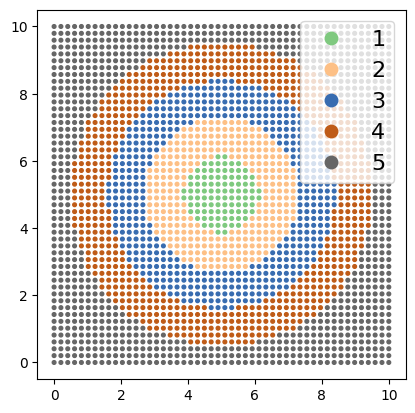

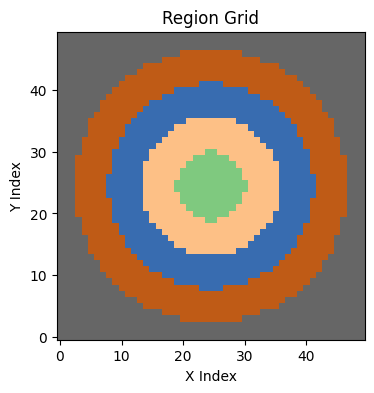

In [53]:
df_circle,gdf_circle = generate_circle_data(2500)
gdf_circle.plot(column='region', categorical=True, cmap='Accent', legend=True, s=7)

size_x = len(np.unique(df_circle['spatial_x']))
size_y = len(np.unique(df_circle['spatial_y']))

region_array = df_circle.sort_values(['spatial_y','spatial_x'])['region'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='Accent', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

In [46]:
df_circle_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_circle['spatial_x'],
    'y_coord': df_circle['spatial_y'],
    'coef0': df_circle['b_list'],
    'coef1': df_circle['a1_list'],
    'coef2': df_circle['a2_list'],
    'feat1':df_circle['feat1'],
    'feat2': df_circle['feat2'],
    'y': df_circle['y'],
    'region': df_circle['region']
})

df_circle_data.to_csv('circle_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_circle_data.shape)

generate data shape = (2500, 11)


### Pattern x

D:\Program Files\Python 3.12.4\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Program Files\Python 3.12.4\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


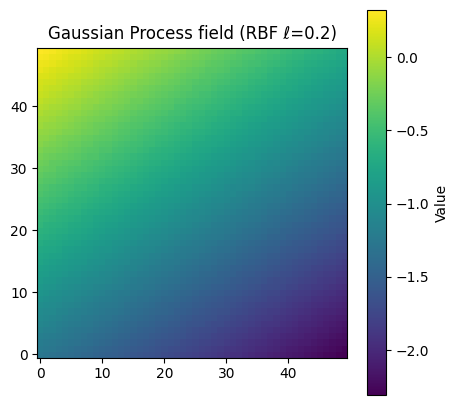

In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

n = 50
x = np.linspace(0, 10, n)
X, Y = np.meshgrid(x, x)
coords = np.column_stack([X.ravel(), Y.ravel()])

kernel = ConstantKernel(5) * RBF(length_scale=0.2)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False )
gp.fit(coords, np.zeros(coords.shape[0]))
sample = gp.sample_y(coords, random_state=42).reshape(n, n)*10**7  # (50,50)

# 把 sample 左右镜像 ---
sample = np.fliplr(sample)  # 或者 sample = sample[:, ::-1]

# 展平成一维，加入到 df_circle
#sample = sample.ravel()  # 长度 50*50 = 2500

plt.figure(figsize=(5,5))
plt.imshow(sample, origin='lower')
plt.colorbar(label='Value')
plt.title('Gaussian Process field (RBF ℓ=0.2)')
plt.show()

In [125]:
df_gau_x_striped,gdf_gau_x_striped = generate_striped_data(2500)
sample_flat = sample.ravel()

noise = np.random.normal(loc=0.0, scale=0.5)
# 5) 把 field 加回 DataFrame
df_gau_x_striped['feat1'] = sample_flat
#df_gau_x_circle['feat2'] = -field
df_gau_x_striped['y'] = df_gau_x_striped['a1_list'] * df_gau_x_striped['feat1'] + df_gau_x_striped['a2_list'] * df_gau_x_striped['feat2'] + df_gau_x_striped['b_list'] + noise
#+ df_gau_x_circle['a2_list'] * df_gau_x_circle['feat2']

df_gau_x_striped_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_gau_x_striped['spatial_x'],
    'y_coord': df_gau_x_striped['spatial_y'],
    'coef0': df_gau_x_striped['b_list'],
    'coef1': df_gau_x_striped['a1_list'],
    'coef2': df_gau_x_striped['a2_list'],
    'feat1':df_gau_x_striped['feat1'],
    'feat2':df_gau_x_striped['feat2'],
    'y': df_gau_x_striped['y'],
    'region': df_gau_x_striped['region']
})

df_gau_x_striped_data.to_csv('striped_gau_x_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_gau_x_circle_data.shape)

generate data shape = (2500, 11)


In [126]:
np.min(sample)

np.float64(-2.306676468148491)

   u  v   x_coord  y_coord  coef0  coef1  coef2     feat1     feat2         y  \
0  0  0  0.000000      0.0    0.0    4.0   -2.0 -1.266675  0.570613 -5.345079   
1  1  0  0.204082      0.0    0.0    4.0   -2.0 -1.284778  0.968185 -6.212634   
2  2  0  0.408163      0.0    0.0    4.0   -2.0 -1.317343 -0.331308 -3.743909   
3  3  0  0.612245      0.0    0.0    4.0   -2.0 -1.337020 -0.612237 -3.260760   
4  4  0  0.816327      0.0    0.0    4.0   -2.0 -1.350071 -1.085151 -2.367135   

   region  
0       1  
1       1  
2       1  
3       1  
4       1  


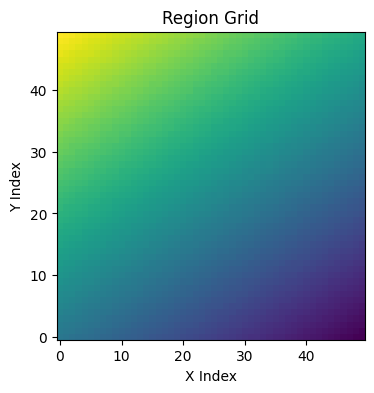

In [128]:
df_test = pd.read_csv("striped_gau_x_data.txt", sep="\t", header=0)

print(df_test.head())

size_x = len(np.unique(df_test['v']))
size_y = len(np.unique(df_test['u']))

region_array = df_test.sort_values(['v','u'])['feat1'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='viridis', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

In [45]:
np.unique(field)
field.shape

(50, 50)

In [86]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

df_gau_x_circle,gdf_gau_x_circle = generate_circle_data(2500)

x = df_circle['spatial_x'].to_numpy()
y = df_circle['spatial_y'].to_numpy()

# 重新计算中心
center_x = 0.5 * (df_circle['spatial_x'].min() + df_circle['spatial_x'].max())
center_y = 0.5 * (df_circle['spatial_y'].min() + df_circle['spatial_y'].max())

r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

# Gussian核函数参数
h = 3   # 带宽
field = np.exp(-0.5 * (r / h)**2)+1

noise = np.random.normal(loc=0.0, scale=0.5)

df_gau_x_circle['feat1'] = field
df_gau_x_circle['feat2'] = -field
df_gau_x_circle['y'] = df_gau_x_circle['a1_list'] * df_gau_x_circle['feat1'] + df_gau_x_circle['a2_list'] * df_gau_x_circle['feat2'] + df_gau_x_circle['b_list'] + noise
#+ df_gau_x_circle['a2_list'] * df_gau_x_circle['feat2']

df_gau_x_circle_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_gau_x_circle['spatial_x'],
    'y_coord': df_gau_x_circle['spatial_y'],
    'coef0': df_gau_x_circle['b_list'],
    'coef1': df_gau_x_circle['a1_list'],
    'coef2': df_gau_x_circle['a2_list'],
    'feat1':df_gau_x_circle['feat1'],
    'feat2':df_gau_x_circle['feat2'],
    'y': df_gau_x_circle['y'],
    'region': df_gau_x_circle['region']
})

df_gau_x_circle_data.to_csv('circle_gau_x_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_gau_x_circle_data.shape)


generate data shape = (2500, 11)


   u  v   x_coord  y_coord  coef0  coef1  coef2     feat1     feat2         y  \
0  0  0  0.000000      0.0   10.0   -3.0    3.0  1.062177 -1.062177  4.489788   
1  1  0  0.204082      0.0   10.0   -3.0    3.0  1.069480 -1.069480  4.445965   
2  2  0  0.408163      0.0   10.0   -3.0    3.0  1.077283 -1.077283  4.399146   
3  3  0  0.612245      0.0   10.0   -3.0    3.0  1.085566 -1.085566  4.349450   
4  4  0  0.816327      0.0   10.0   -3.0    3.0  1.094299 -1.094299  4.297053   

   region  
0       5  
1       5  
2       5  
3       5  
4       5  


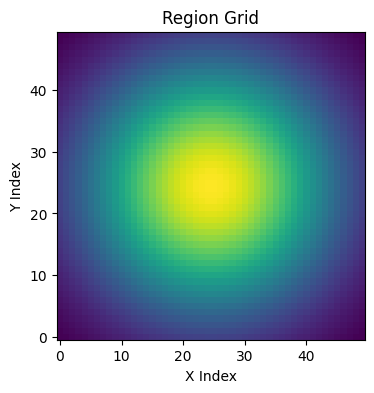

In [91]:
df_test = pd.read_csv("circle_gau_x_data.txt", sep="\t", header=0)

print(df_test.head())

size_x = len(np.unique(df_test['v']))
size_y = len(np.unique(df_test['u']))

region_array = df_test.sort_values(['v','u'])['feat1'].to_numpy()
region_grid = region_array.reshape(size_y, size_x)

plt.figure(figsize=(6,4))
plt.imshow(region_grid, cmap='viridis', origin='lower')
#plt.colorbar(label='Region')
plt.title('Region Grid')
plt.xlabel('X Index')
plt.ylabel('Y Index')
plt.show()

## Different Error

## Voronoi

In [189]:
def generate_diff_err_voronoi_data(n_points=500, 
                          x_min=0, x_max=10,
                          y_min=0, y_max=10,
                          random_seed=42,
                          error_scales=None):

    np.random.seed(random_seed)

    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    feat1 = np.random.normal(0, 1, n_points)
    feat2 = np.random.normal(0, 1, n_points)

    seed_idx = np.random.choice(n_points, size=5, replace=False)
    seed_x = x_spatial[seed_idx]
    seed_y = y_spatial[seed_idx]

    region = np.empty(n_points, dtype=int)
    for i in range(n_points):
        d2 = (x_spatial[i] - seed_x)**2 + (y_spatial[i] - seed_y)**2
        region[i] = np.argmin(d2) + 1   # +1 让 region 从 1 到 5

    a1_list = [4.0, 2.0, 0.5, -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3.0, -0.5, 3.0]
    b_list  = [0.0, 1.0, 5.0, 0.0, 10.0]
    # 噪声标准差
    if error_scales is None:
        error_scales = [0.5, 1.0, 1.5, 2.0,2.5]

    y = np.zeros(n_points)
    a1_array = np.zeros(n_points)
    a2_array = np.zeros(n_points)
    b_array  = np.zeros(n_points)
    error_array = np.zeros(n_points)
    
    for i in range(n_points):
        r = region[i] - 1
        sigma = error_scales[r]
        noise = np.random.normal(loc=0.0, scale=sigma)
        
        y[i] = (a1_list[r] * feat1[i] 
              + a2_list[r] * feat2[i] 
              + b_list[r] 
              + noise)
        a1_array[i] = a1_list[r]
        a2_array[i] = a2_list[r]
        b_array[i]  = b_list[r]
        error_array[i] = noise

    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
        'region': region})

    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return df, gdf

In [190]:
df_diff_err_voronoi,gdf_diff_err_voronoi = generate_diff_err_voronoi_data(2500)

In [191]:
df_diff_err_voronoi_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_diff_err_voronoi['spatial_x'],
    'y_coord': df_diff_err_voronoi['spatial_y'],
    'coef0': df_diff_err_voronoi['b_list'],
    'coef1': df_diff_err_voronoi['a1_list'],
    'coef2': df_diff_err_voronoi['a2_list'],
    'feat1':df_diff_err_voronoi['feat1'],
    'feat2': df_diff_err_voronoi['feat2'],
    'y': df_diff_err_voronoi['y'],
    'region': df_diff_err_voronoi['region']
})

df_diff_err_voronoi_data.to_csv('voronoi_diff_err_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_diff_err_voronoi_data.shape)

generate data shape = (2500, 11)


## Circle

In [192]:
def generate_diff_err_circle_data(n_points=500, 
                                  x_min=0, x_max=10,
                                  y_min=0, y_max=10,
                                  random_seed=42,
                                 error_scales=None):
    np.random.seed(random_seed)

    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    feat1 = np.random.normal(0, 1, n_points)
    feat2 = np.random.normal(0, 1, n_points)

    # 5个等宽圆环

    center_x = 0.5 * (x_min + x_max)
    center_y = 0.5 * (y_min + y_max)
  
    distances = np.sqrt((x_spatial - center_x)**2 + (y_spatial - center_y)**2)

    max_radius = 0.8*distances.max()
    thresholds = np.linspace(0, max_radius, num=6)[1:-1]
    region = np.digitize(distances, thresholds) + 1

    # 4) 按 region 生成 y, a1, a2（不变）
    a1_list = [4.0, 2.0, 0.5, -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3.0, -0.5, 3.0]
    b_list  = [0.0, 1.0, 5.0, 0.0, 10.0]

    if error_scales is None:
        error_scales = [0.5, 1.0, 1.5, 2.0,2.5]

    y = np.zeros(n_points)
    a1_array = np.zeros(n_points)
    a2_array = np.zeros(n_points)
    b_array  = np.zeros(n_points)
    error_array = np.zeros(n_points)
    
    for i in range(n_points):
        r = region[i] - 1
        sigma = error_scales[r]
        noise = np.random.normal(loc=0.0, scale=sigma)
        
        y[i] = (a1_list[r] * feat1[i] 
              + a2_list[r] * feat2[i] 
              + b_list[r] 
              + noise)
        a1_array[i] = a1_list[r]
        a2_array[i] = a2_list[r]
        b_array[i]  = b_list[r]
        error_array[i] = noise

    # --------- 步骤 5：组装 DataFrame ---------
    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
        'region': region
    })

    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return df, gdf

In [193]:
df_diff_err_circle,gdf_diff_err_circle = generate_diff_err_circle_data(2500)

In [194]:
df_diff_err_circle_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_diff_err_circle['spatial_x'],
    'y_coord': df_diff_err_circle['spatial_y'],
    'coef0': df_diff_err_circle['b_list'],
    'coef1': df_diff_err_circle['a1_list'],
    'coef2': df_diff_err_circle['a2_list'],
    'feat1':df_diff_err_circle['feat1'],
    'feat2': df_diff_err_circle['feat2'],
    'y': df_diff_err_circle['y'],
    'region': df_diff_err_circle['region']
})

df_diff_err_circle_data.to_csv('circle_diff_err_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_diff_err_circle_data.shape)

generate data shape = (2500, 11)


## Different Shape of Coefs

In [205]:
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def generate_diff_shp_striped_data(n_points=500, 
                          x_min=0, x_max=10,
                          y_min=0, y_max=10,
                          random_seed=42,
                          noise_scale=0.5):
    """
    生成条状数据：
      region1 (a1) 按 x+y 分成 5 条斜带
      region2 (a2) 按 x−y 分成 5 条垂直斜带
      a1 从 a1_list 中取值，a2 从 a2_list 中取值
      b 还是按 region1 取值
      y = a1*feat1 + a2*feat2 + b + noise
    """
    np.random.seed(random_seed)

    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x_spatial = xx.ravel()[:n_points]
    y_spatial = yy.ravel()[:n_points]

    feat1 = np.random.normal(0, 1, n_points)
    feat2 = np.random.normal(0, 1, n_points)

    # 用 x+y 划分 region1（a1）
    xy_sum = x_spatial + y_spatial
    th1 = np.linspace(xy_sum.min(), xy_sum.max(), 6)[1:-1]
    region1 = np.digitize(xy_sum, bins=th1) + 1

    # 用 x−y 划分 region2（a2）
    xy_diff = x_spatial - y_spatial
    th2 = np.linspace(xy_diff.min(), xy_diff.max(), 6)[1:-1]
    region2 = np.digitize(xy_diff, bins=th2) + 1

    a1_list = [4.0, 2.0, 0.5, -1.5, -3.0]
    a2_list = [-2.0, 4.0, -3.0, -0.5, 3.0]
    b_list  = [0.0, 1.0, 5.0, 0.0, 10.0]

    a1_array = np.array([a1_list[r-1] for r in region1])
    a2_array = np.array([a2_list[r-1] for r in region2])
    b_array  = np.array([ b_list[r-1] for r in region1])  # b 仍用 region1

    noise = np.random.normal(loc=0.0, scale=0.5)
    y = a1_array*feat1 + a2_array*feat2 + b_array + noise

    df = pd.DataFrame({
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list': b_array,
        'feat1': feat1,
        'feat2': feat2,
        'y': y,
    })
    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    return df, gdf

df_diff_shp_striped, gdf_diff_shp_striped = generate_diff_shp_striped_data(n_points=2500, noise_scale=0.5)


In [207]:
df_diff_shp_striped_data = pd.DataFrame({
    'u':     u.astype(int),       # 或保留原始浮点
    'v':     v.astype(int),
    'x_coord': df_diff_shp_striped['spatial_x'],
    'y_coord': df_diff_shp_striped['spatial_y'],
    'coef0': df_diff_shp_striped['b_list'],
    'coef1': df_diff_shp_striped['a1_list'],
    'coef2': df_diff_shp_striped['a2_list'],
    'feat1':df_diff_shp_striped['feat1'],
    'feat2': df_diff_shp_striped['feat2'],
    'y': df_diff_shp_striped['y'],
})

df_diff_shp_striped_data.to_csv('striped_diff_shp_data.txt', 
          sep='\t', 
          index=False, 
          float_format='%.6f')

print("generate data shape =", df_diff_shp_striped_data.shape)

generate data shape = (2500, 10)


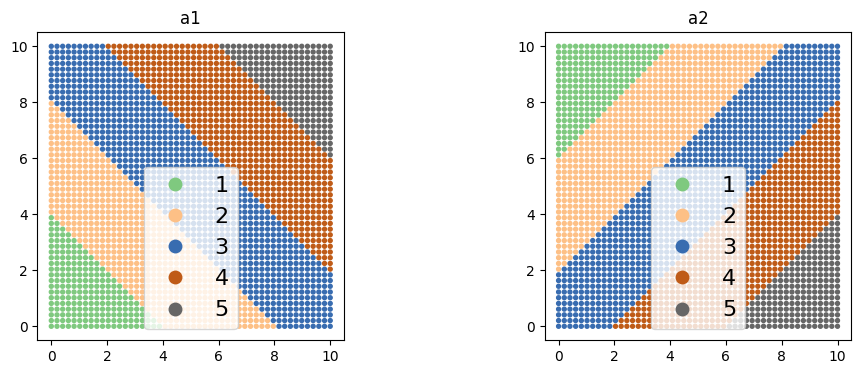

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
gdf.plot(column='region1', categorical=True, legend=True, ax=axes[0], cmap='Accent', markersize=8)
axes[0].set_title('a1')
gdf.plot(column='region2', categorical=True, legend=True, ax=axes[1], cmap='Accent', markersize=8)
axes[1].set_title('a2')
plt.show()